### Gradient Descent and Autograd

In [2]:
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pylab as plt

In [23]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [24]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

In [17]:
import torch
import numpy as np
import random

def set_seed(seed=2021):
    """Set the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def set_device():
    """Set the device to GPU if available, otherwise CPU."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

# Set the seed for reproducibility
SEED = 2021
set_seed(seed=SEED)

# Set the device to use GPU if available, otherwise CPU
DEVICE = set_device()


Using CPU


In [18]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Using CPU


In [19]:
def fun_z(x, y):
    z = np.sin(x**2 + y**2)
    return z

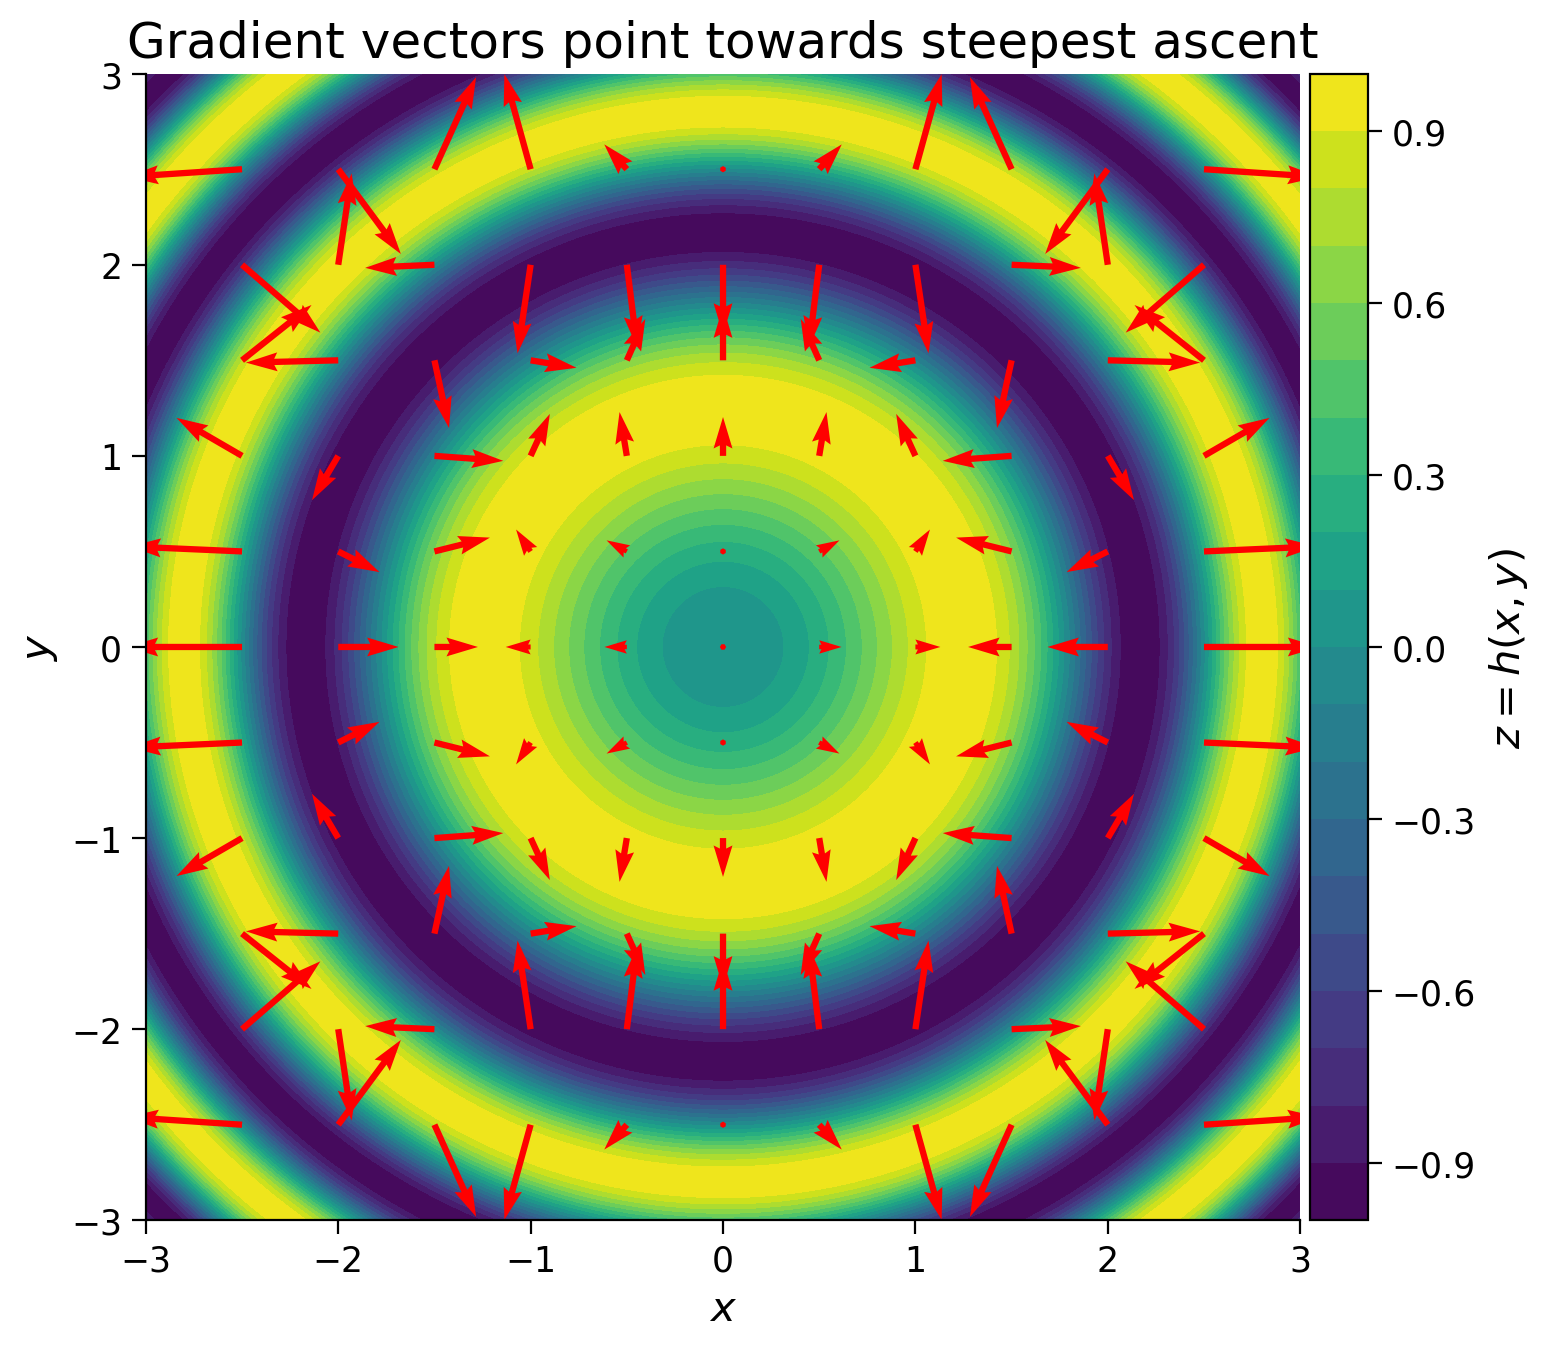

In [25]:
def fun_dz(x, y):
    dz_dx = 2*x*np.cos(x**2 + y**2)
    dz_dy = 2*y*np.sin(x**2 + y**2)
    return dz_dx, dz_dy
## Uncomment to run
ex1_plot(fun_z, fun_dz)

In [26]:
class SimpleGraph:
    def __init__(self, w, b):
        assert isinstance(w, float)
        assert isinstance(b, float)
        self.w = torch.tensor([w], requires_grad=True)
        self.b = torch.tensor([b], requires_grad=True)
    def forward(self, x):
        assert isinstance(x, torch.Tensor)
        prediction = torch.tanh((self.w * x) + self.b)
        return prediction
def sq_loss(y_true, y_prediction):
        assert isinstance(y_true, torch.Tensor)
        assert isinstance(y_prediction, torch.Tensor)
        loss = y_true - y_prediction
        return loss
feature = torch.tensor([1])  # Input tensor
target = torch.tensor([7])  # Target tensor


simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

initial weight = -0.5, 
initial bias = 0.5
for x=1 and y=7, prediction=0.0, and L2 Loss = 7.0


In [27]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a + b
print(f'Gradient function = {c.grad_fn}')

Gradient function = <AddBackward0 object at 0x000002CC8B196D40>


In [28]:
print(f'Gradient function for prediction = {prediction.grad_fn}')
print(f'Gradient function for loss = {square_loss.grad_fn}')

Gradient function for prediction = <TanhBackward0 object at 0x000002CC877AAB30>
Gradient function for loss = <SubBackward0 object at 0x000002CC8B197760>


In [29]:
# Analytical gradients (Remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # First we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad  # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad  # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([False])
tensor([False])


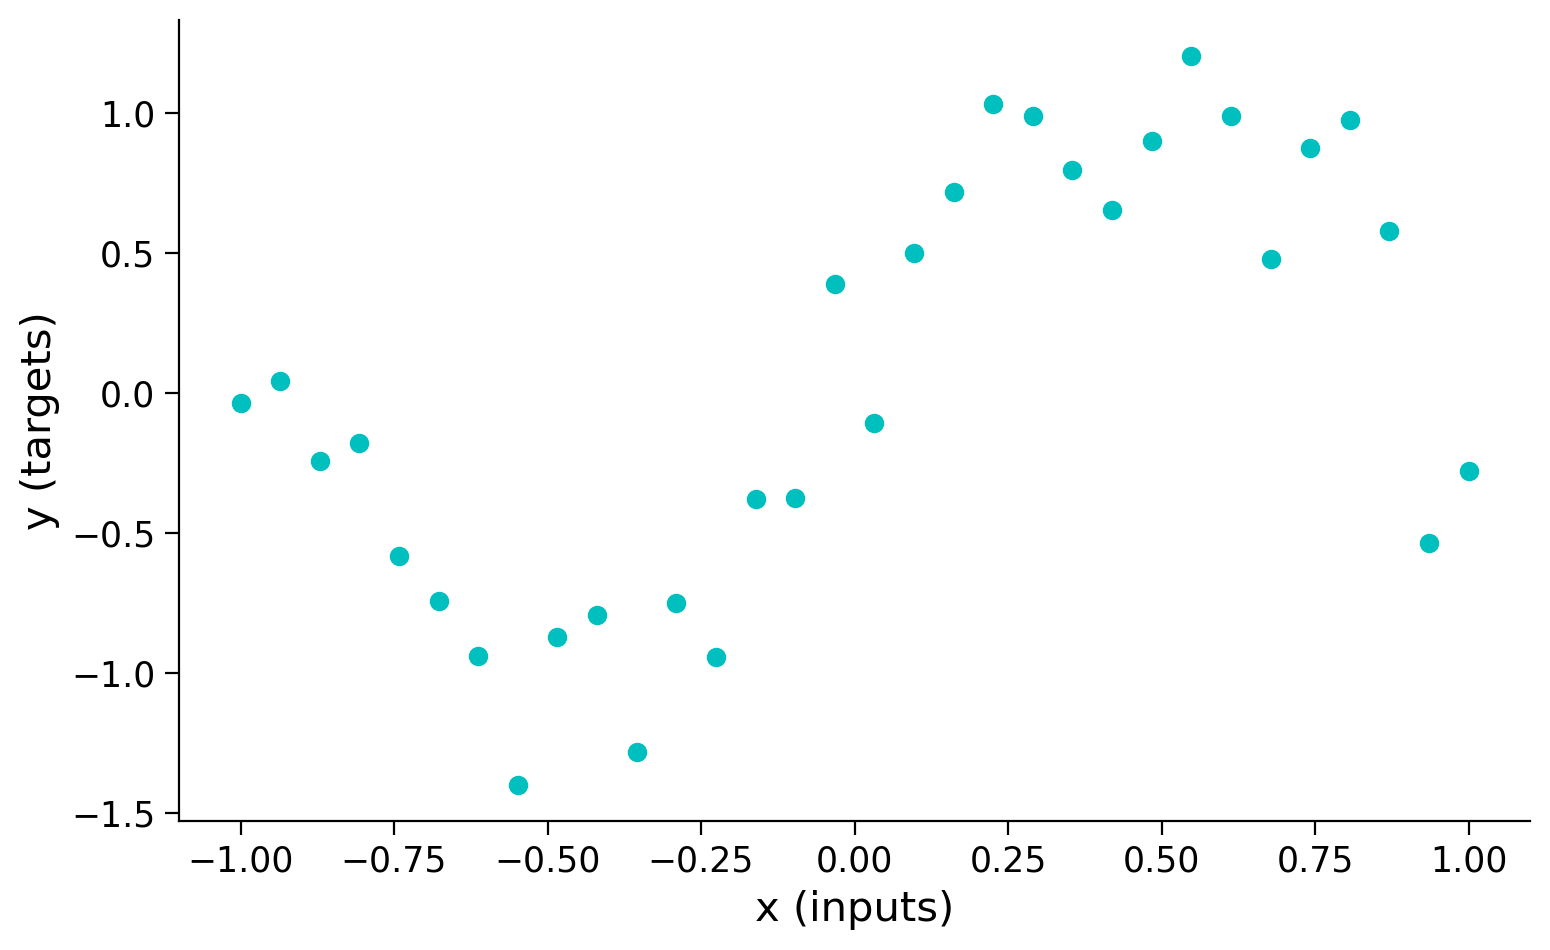

In [37]:
# @markdown #### Generate the sample dataset
set_seed(seed=SEED)
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

### Widenet

In [31]:
class WideNet(nn.Module):
    def __init__(self):
        super().__init__()
        n_cells = 512
        self.layers = nn.Sequential(
            nn.Linear(1, n_cells),
            nn.Tanh(),
            nn.Linear(n_cells, 1)
        )
    def forward(self, x):

        return self.layers(x)

In [32]:
# Creating an instance
SEED = 2021
set_seed(seed=SEED)
wide_net = WideNet()
print(wide_net)

WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


### Loss function and optimizer

In [33]:
# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

In [34]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

Loss: 0.8889423608779907


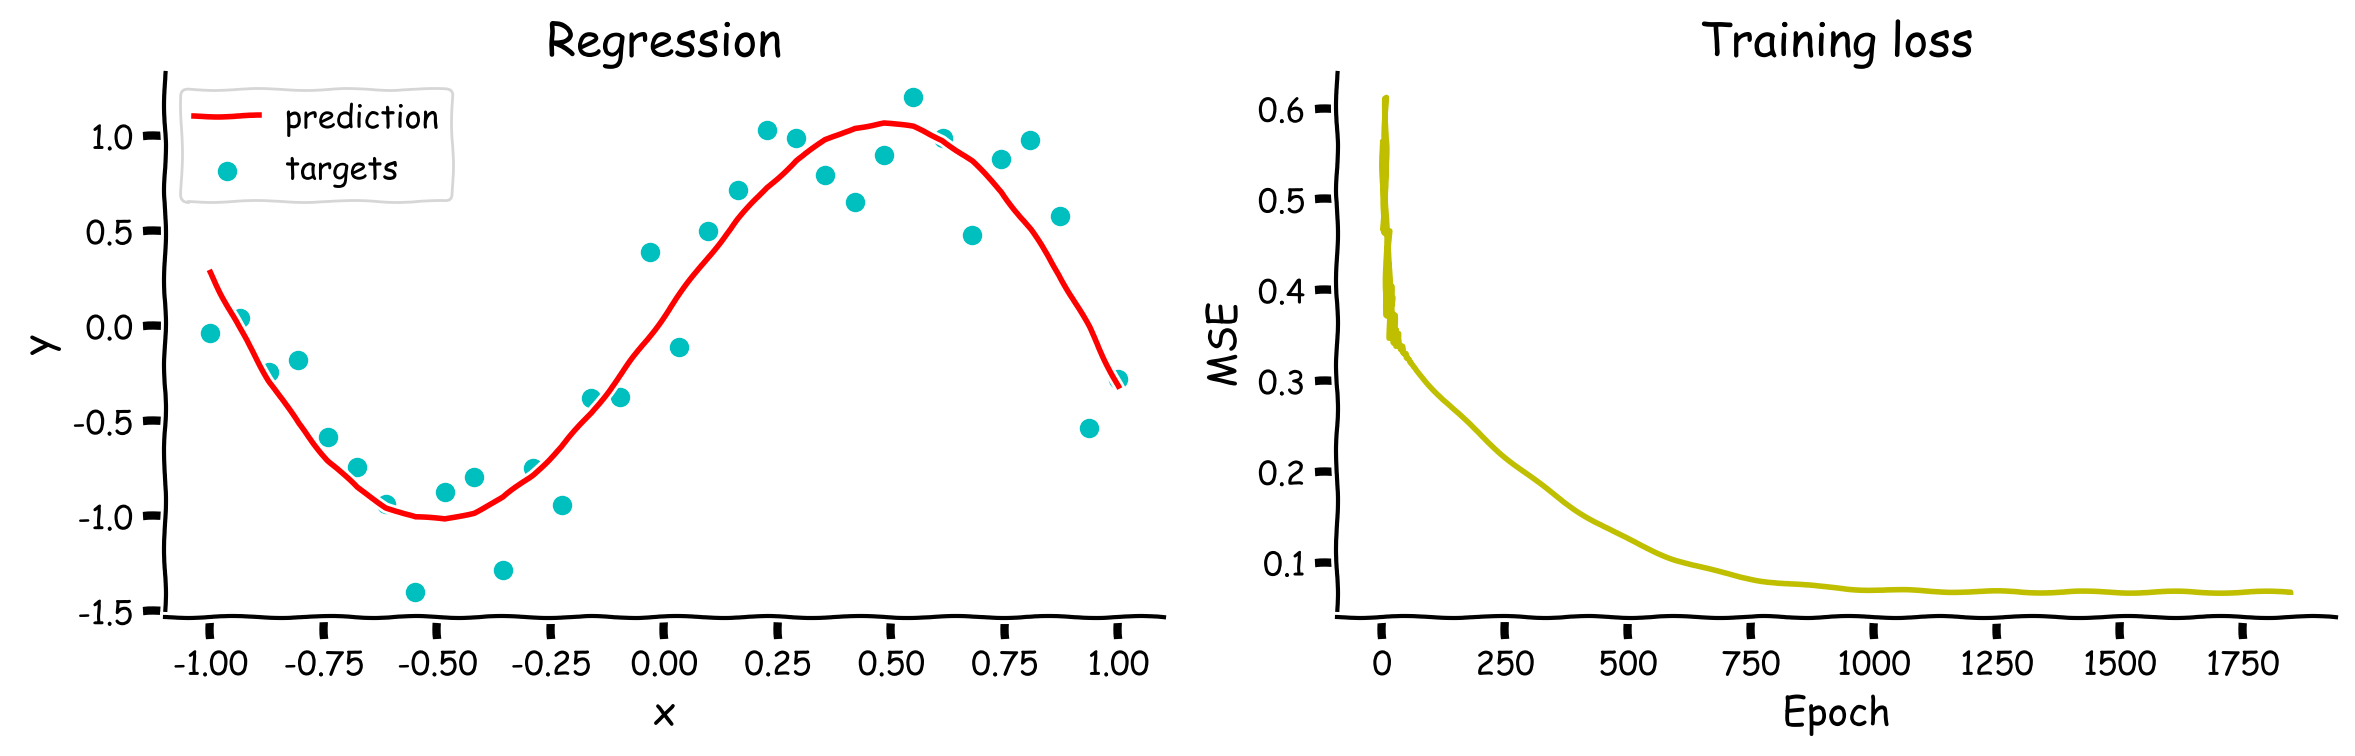

In [35]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
    """
    Training function

    Args:
        features: torch.Tensor
        Features (input) with shape torch.Size([n_samples, 1])
        labels: torch.Tensor
        Labels (targets) with shape torch.Size([n_samples, 1])
        model: torch nn.Module
        The neural network
        loss_fun: function
        Loss function
        optimizer: function
        Optimizer
        n_epochs: int
        Number of training iterations

    Returns:
        loss_record: list
        Record (evolution) of training losses
    """
    loss_record = []
    for _ in range(n_epochs):
        optimizer.zero_grad()
        predictions = model(features)
        loss = loss_fun(predictions, labels)
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
    return loss_record
set_seed(seed=2021)
epochs = 1847 # Cauchy
losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs);
with plt.xkcd():
  ex3_plot(wide_net, inputs, targets, epochs, losses)